CM2015 L10C
Author: Leroy Ng
Date: 15/10/2024

<h3 style="color: green; font-weight: bold">Impact of Daily Game Volume on Win Rate and KDA in League of Legends: Project Proposal</h3>

<h4>Determining Whether the Number of Games Played in a Day Will Influence Win/Loss Ratio and KDA in League of Legends</h3>

League of Legends is one of the most popular competitive games where players will battle against in each other in squads of 5. There have been many strategies and techniques that players have developed over the years to help them win more, and sepculating the optimal number of games to play per day is one of them. Many players speculate that playing less games a day will increase rank progression overall by average, due to factors such as mental fatigue which can affect performance, resulting in more losses.

This project aims to identify wether there is any correlation between number of games played in a day, and rank progression/game performance. 
<h3 style="font-style: italic">Directory:</h3>

1. **Gathering Player Names from the Top 200 Players in the SG2 Region:**
    - 1.0 Webscraping Raw Player Name Data from leagueofgraphs.com
    - 1.1 Cleaning the Raw Player Name Data

2. **Gather Match History: For each player, obtain the PUUID to then fetch the match history for the player:**
    - 2.1 Creating the Functions to fetch Player UUID and the Match History through API calls
    - 2.2 Running the function to fetch the Players UUID and Match History and adding it to sg2_names_CLEANED.csv
    - 2.3 Creating Function to fetch Match Statistics based on the Fetched match_history_ids
    - 2.4 Using the Created Function to fetch Match Statistics based on the Fetched match_history_ids
        - ⚠️ Estimated run time for this step is 2hrs+ due to rate limits imposed, but I already have a file with the outputted data saved as "sg2_names_CLEANED_updated.csv" if you would like to skip the fetching process.
    - 2.5 Changing the Format of the fetched Match Statistics to the appropriate format

3. **Calculate Average Game Count and Win/Loss Ratio and KDA, and creating a new CSV file with the cleaned necessary data**
    - 3.1 Adding Average Game Count
    - 3.2 Adding Win/Loss ratio
    - 3.3 Adding KDA to the dataframe
    - 3.4 Cleaning the Dataframe    

4. **Visualising the Data to determine the ideal number of games to play in a day**
    - 4.1 Plotting a scatter-graph
    - 4.2 Plotting a Co-relation Heatmap graph

### Data Collection:
- Region: We will focus exclusively on the SG2 (Singapore) region.
- Player Sample: The sample will include only the top 200 players by rank in the SG2 region to make sure that the sample is representative of the top players in the region.
- Data Sources: All data will be gathered through Riot's Developer API.

In [ ]:
# import libraries
import numpy as np
import pandas as pd
import requests
import time
from datetime import datetime
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

print("Imports Complete")

<h3>1.0 <span style="color: green">Web Scraping</span> raw player name data from leagueofgraphs.com</h3>

In this section, I will be scraping the raw player name data from leagueofgraphs.com and store it in a CSV file called sg2_names_RAW.csv.

To ensure that the data is available to be scraped, I added a time.sleep of 10 seconds to allow the page to load.

<span style="color:red">Estimated run time: </span>40s-70s 


In [6]:
# selenium Webdriver setup (for extracting data dynamically loaded in JS)
driver_path = './drivers/chromedriver.exe'
service = Service(driver_path)
driver = webdriver.Chrome(service=service)

# buffer time for loading JS, made it 10seconds to be extra safe in case the page takes longer to load
time.sleep(10)

driver.get('https://www.leagueofgraphs.com/rankings/summoners/sg')

# from inspecting the website, I found the data in a <table> with a data_table class name, so we use BeautifulSoup library to find the data from the table
soup = BeautifulSoup(driver.page_source, 'html.parser')
table = soup.find('table', {'class' : 'data_table'})
headers = [header.text.strip() for header in table.find_all('th')]
rows = table.find('tbody').find_all('tr')

#create a player_names list
player_names = []

for row in rows:
    cols = row.find_all('td')
    player_info = [col.text.strip() for col in cols]
    player_names.append(player_info)
    
# create a pandas Dataframe from player_names and save it to a CSV
df = pd.DataFrame(player_names, columns=headers)
df.to_csv('sg2_names_RAW.csv', index=False)

print('Data succesfully scraped to sg2_names_RAW.csv \n\n')

driver.quit()


Data succesfully scraped to sg2_names_RAW.csv 




<h3>1.1 <span style="color: green">CLEANING</span> RAW PLAYER NAME DATA</h3>

In this section I will clean the webscraped player name data and store the cleaned data in a new csv file called sg2_names_CLEANED.csv

In [7]:
# Load the CSV data and skip the first two rows that don't contain player data
df = pd.read_csv("sg2_names_RAW.csv", header=None, skiprows=2)
df.columns = ["Index", "Player Info", "Soloqueue Rank", "Draft Ranked Flex", "Most Played Champions"]

# Convert player info to string to avoid attribute errors
df['Player Info'] = df['Player Info'].astype(str)

# Extract Player Name and tag
df['Player Name'] = df['Player Info'].str.extract(r'^([^#\n]+#[^#\n]+)(?=\n)')[0].str.strip()

df['Region Rank'] = df['Player Info'].str.extract(r"SG\s*\(#(\d+)\)")[0].fillna('')
df['Region'] = 'SG'

# Convert soloq rank to string
df['Soloqueue Rank'] = df['Soloqueue Rank'].astype(str)

# get rank tier and lp from soloq rank
df['Rank Tier'] = df['Soloqueue Rank'].str.extract(r"^(Challenger|GrandMaster|Master|Diamond|Platinum|Gold|Silver|Bronze)")[0]
df['LP'] = df['Soloqueue Rank'].str.extract(r"(\d+)\s*LP")[0].astype(float)

# Drop the rest
df_cleaned = df.drop(columns=["Index", "Player Info", "Soloqueue Rank", "Draft Ranked Flex", "Most Played Champions"])
df_cleaned.to_csv('sg2_names_CLEANED.csv', index=True)


print('"sg2_names_RAW.csv" Succesfully cleaned and organised as "sg2_names_CLEANED" \n\n')
df_cleaned.head(10)


"sg2_names_RAW.csv" Succesfully cleaned and organised as "sg2_names_CLEANED" 




<h3>2.0 Adding Match History and Match statistics Related Data</h3>

Now that we have a cleaned list of player names along with their Region Rank, Region, Rank Tier and LP, we can use the Riot API to fetch the match history and Match Statistics for each player. 

Since the Riot API for fetching Match History ID's requires the players UUID which we do not have, we must first fetch the players account UUID. Only then can we pass the UUID into the Riot API for fetching the Match History ID's, which we can then use to fetch the Match Data and Statistics.

---------------------------------------------------------------------------------------------

<h4>2.1 Creating the Functions to fetch Player UUID and the Match History through API calls</h4>

First we create the functions to fetch the match history for each player from the official Riot API.


In [8]:
from config import RIOT_API_KEY

# set the api variables
API_MATCH = f"https://sea.api.riotgames.com/lol/match/v5/matches"
API_ACCOUNT = f"https://asia.api.riotgames.com/riot/account/v1/accounts/by-riot-id"

# got from the developer.riotgames.com Developer Portal
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36",
    "Accept-Language": "en-GB,en;q=0.9,zh-CN;q=0.8,zh;q=0.7,en-US;q=0.6",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com",
    "X-Riot-Token": RIOT_API_KEY
}

# function to fetch PUUID by the Riot ID (game name and tagline)
def get_puuid(game_name, tagline):
    response = requests.get(f"{API_ACCOUNT}/{game_name}/{tagline}", headers=headers)
    if response.status_code == 200:
        return response.json()['puuid']
    else:
        print("Failed to fetch PUUID:", response.json())
        return None

# function to fetch match history (past 40 ranked games) of player by their uuid
def get_match_history_ids(puuid):
    response = requests.get(f"{API_MATCH}/by-puuid/{puuid}/ids?count=40&type=ranked", headers=headers)
    if response.status_code == 200:
        return response.json()
    else:
        print("Failed to fetch match history:", response.json())
        return None

print("get_puuid and get_match_history functions successfully created\n\n")

get_puuid and get_match_history functions successfully created




<h4>2.2 Running the function to fetch the Players UUID and Match History and adding it to sg2_names_CLEANED.csv</h4>

In this next step, I use the created functions above to fetch the Players UUID from the Player Name, and fetch the past 20 Match IDs from the Match History function based on the UUID of the player.

The Match History is then added into the sg2_names_CLEANED.csv file in a new field (match_history_ids) as a string.

<span style="color:red">Estimated run time: </span> ~150s-180s

In [9]:
# Read the cleaned player names
df_players = pd.read_csv('sg2_names_CLEANED.csv')

# Create a list to store match histories
match_histories = []

# Iterate through each player
for index, row in df_players.iterrows():
     # Skip if player name is NaN/null
    if pd.isna(row['Player Name']):
        print(f"Skip {index + 1} due to missing player name")
        continue
    
    # Split the player name into game name and tagline
    game_name, tagline = row['Player Name'].split('#')
    print(f"Fetching data for player {index + 1}/100: {game_name}#{tagline}")
    
    try:
        # Get PUUID using both game name and tagline
        puuid = get_puuid(game_name, tagline)
        
        if puuid:
            # Get match history
            matches = get_match_history_ids(puuid)
            
            if matches:
                # Store player data with match history
                player_data = {
                    'player_name': row['Player Name'],
                    'rank_tier': row['Rank Tier'],
                    'lp': row['LP'],
                    'region_rank': row['Region Rank'],
                    'match_history_ids': matches  # Store the entire list of match IDs
                }
                match_histories.append(player_data)
        
    except Exception as e:
        print(f"Error processing {row['Player Name']}: {str(e)}")
        continue

# Create DataFrame from collected data
df_matches = pd.DataFrame(match_histories)

# Save to CSV with match_history_ids as a string (CSV can't store lists directly)
df_matches['match_history_ids'] = df_matches['match_history_ids'].apply(lambda x: ','.join(x))
df_matches.to_csv('sg2_names_CLEANED.csv', index=False)

print("\nMatch history Id's successfully saved to sg2_names_CLEANED.csv \n\n")
df_matches.head(10)

Fetching data for player 1/100: Faker#031
Fetching data for player 2/100: Sevaski#aaa
Fetching data for player 3/100: NekoDesu#1009
Fetching data for player 4/100: Inevitabilis#Death
Fetching data for player 5/100: Faker#5STAR
Fetching data for player 6/100: Yril#Yril
Fetching data for player 7/100: 白狐狸#Fxx
Skip 8 due to missing player name
Fetching data for player 9/100: 瞬間即是永恆#37a1
Fetching data for player 10/100: chatrestricted#1269
Fetching data for player 11/100: 死亡聆听#jug
Fetching data for player 12/100: dogwifhat#5730
Fetching data for player 13/100: polop#SG2
Fetching data for player 14/100: FP Poppy#SG2
Fetching data for player 15/100: NekoDesu#Troll
Fetching data for player 16/100: 웨이빈03#Moo
Fetching data for player 17/100: Gubb#6366
Fetching data for player 18/100: Inserial#SG2
Fetching data for player 19/100: 他在家里显得很弱势总是窝里受气#123
Fetching data for player 20/100: watermelon123#aaa
Fetching data for player 21/100: AMG#SG2
Fetching data for player 22/100: DR PHIL#CRACK
Fetching 

<h4>2.3 Creating Function to fetch Match Statistics based on the Fetched match_history_ids</h4>

The Functions created here are to fetch the Match Statistics for each match id. This will be run in the next section 2.4

<span style="color:red">Estimated run time: </span> 0s

In [10]:
API_MATCH_STATS = "https://sea.api.riotgames.com/lol/match/v5/matches/"

# from the Riot API documentation
headers = {
 "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36",
    "Accept-Language": "en-GB,en;q=0.9,zh-CN;q=0.8,zh;q=0.7,en-US;q=0.6",
    "Accept-Charset": "application/x-www-form-urlencoded; charset=UTF-8",
    "Origin": "https://developer.riotgames.com",
    "X-Riot-Token": RIOT_API_KEY
}

def get_match_data(match_id):
    
    try:
        response = requests.get(f"{API_MATCH_STATS}{match_id}", headers=headers)
        if response.status_code == 200:
            match_data = response.json()
            
            # Find participant data
            for participant in match_data['info']['participants']:
                # Calculate KDA
                deaths = participant['deaths'] if participant['deaths'] > 0 else 1
                kda = (participant['kills'] + participant['assists']) / deaths
                
                return {
                    'match_id': match_id,
                    'win': participant['win'],
                    'gameCreation': match_data['info']['gameCreation'],
                    'kda': round(kda, 2)
                }
        else:
            print(f"Error fetching match {match_id}: {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Exception for match {match_id}: {str(e)}")
        return None



<h4>2.4 Using the Created Function to fetch Match Statistics based on the Fetched match_history_ids</h4>

<h4 style="color: red; font-weight: bold"> IMPORTANT NOTE:</h4> Since the MATCH v5 API has a rate limit of 200 requests per minute, I will be implementing a time.sleep of (0.8) seconds between each API call. Below is all the data i wil be fetching from the API:

- For each of the 40 Matches a Player has, I will be pulling the below match data
    - win (boolean)
    - gameCreation (unix time)
    - kda (float)

- This process will be repeated for all 100 Players.

The data required will be quite a large amount, so it will take a very long time (2hr++) to complete due to the rate limits. 

<span style="color:green; font-weight: bold">I already have a file with the outputted data saved as "sg2_names_CLEANED_updated.csv" if you would like to skip the fetching process.</span><br><br>

<span style="color:red">Estimated run time: </span>2hrs+ 


In [11]:
# Read the CSV file
df = pd.read_csv('sg2_names_CLEANED.csv')

# loop through each row in the dataframe
for index, row in df.iterrows():
    print(f"\nProcessing match history for player {index + 1} out of {len(df)}: {row['player_name']}")
    
    # to get the total number of match ids for a progress bar
    match_ids = row['match_history_ids'].split(',')
    match_data_list = []
    total_matches = len(match_ids)
    
    # get match data for each match id
    for id_num, match_id in enumerate(match_ids, 1):
        # Add sleep btw each call to prevent hitting the rate limit
        time.sleep(0.8)
        
        print(f"{id_num} out of {total_matches}: {match_id}")
        match_data = get_match_data(match_id.strip())
        if match_data:
            match_data_list.append(match_data)
    
    # Update the dataframe with the new match data
    df.at[index, 'match_data'] = str(match_data_list)
    
    # Save progress periodically
    if (index + 1) % 5 == 0:
        df.to_csv('sg2_names_CLEANED_updated.csv', index=False)
        print(f"Progress saved after processing {index + 1} players")

# Final save
df.to_csv('sg2_names_CLEANED_updated.csv', index=False)
print("\nProcessing complete! Data saved to sg2_names_CLEANED_updated.csv")


Processing match history for player 1 out of 100: Faker#031
1 out of 40: SG2_41402180
2 out of 40: SG2_41216261
3 out of 40: SG2_41210887
4 out of 40: SG2_41017998
5 out of 40: SG2_40924119
6 out of 40: SG2_40916143


KeyboardInterrupt: 

<h3>2.5 Changing the Format of the fetched Match Statistics to the appropriate format</h3>
Since the fetched data from the MATCH V5 API are not displayed in the appropriate format for deducing the statistics, we need to format the required Statistics to the correct formats.

<h4>What are we changing?</h4>
1. gameCreation Unix Timestamp to Date format (eg. 16 November 2024)
 - To gather all the games played in the same day. The exact timing is not needed.

Everything else can be kept the same.

<span style="color:red">Estimated run time: </span> ~1s



In [12]:
# Read the CSV file to a df
df = pd.read_csv('sg2_names_CLEANED_updated.csv')

# Convert the data in the df that represent JSON like object to actual dictionaries etc
df['match_data'] = df['match_data'].apply(eval)

# Function to convert unix timestamp to date string
def convert_timestamp(match_list):
    for match in match_list:
        # Convert milliseconds to seconds by dividing by 1000
        timestamp = match['gameCreation'] / 1000
        # Convert to datetime and format as YYYY-MM-DD
        date_str = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
        match['gameCreation'] = date_str
    return match_list

# Apply the function to each rows match_data
df['match_data'] = df['match_data'].apply(convert_timestamp)

# Save to new CSV file Final_Raw_Data.csv
df.to_csv('Final_Raw_Data.csv', index=False)

<h3>3.0 Calculate and Add Average Game Count and Win/Loss Ratio</h3>

-------------------------------------------------------------------

<h4>3.1 Adding Average Game Count</h4>
In this section, I will calculate the Average number of games played in a day by each player over the course of their past 40 Ranked Games.

<span style="font-style:italic; font-size:120%">How will I do this?</span><br>
For each player, over their past 40 games, calculate the total number of days from the oldest game to the newest game played. Then calculate the average number of games played per day by dividing the total number of games by the total number of days.


In [19]:
# Create new df from Final_Raw_Data.csv
df = pd.read_csv('Final_Raw_Data.csv')

# Convert match_data json obj to dictionairies
df['match_data'] = df['match_data'].apply(eval)

#Creating the function to calculate Average daily games
def calculate_daily_average(match_data):
    # Extract all dates
    dates = set(match['gameCreation'] for match in match_data)
    
    # Convert to datetime for proper date calculations
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]
    
    # Calculate date range (add 1 to include both start and end dates)
    date_range = (max(dates) - min(dates)).days + 1
    
    # Calculate average (total games divided by number of days)
    return len(match_data) / date_range

# Create new dataframe with required columns and calculate daily average
df_stats = pd.DataFrame({
    'player_name': df['player_name'],
    'rank_tier': df['rank_tier'],
    'lp': df['lp'],
    'dailyAverage': df['match_data'].apply(calculate_daily_average)
})

# Round dailyAverage to 2 decimal places for cleaner display
df_stats['dailyAverage'] = df_stats['dailyAverage'].round(2)

print("Daily averages calculated successfully\n\n")
df_stats.head(10)

Daily averages calculated successfully




,player_name,rank_tier,lp,dailyAverage
0,Faker#031,Challenger,1219.0,2.00
1,Sevaski#aaa,Challenger,1078.0,3.33
2,NekoDesu#1009,Challenger,693.0,1.67
3,Inevitabilis#Death,GrandMaster,424.0,4.44
4,Faker#5STAR,GrandMaster,348.0,3.08
5,Yril#Yril,GrandMaster,314.0,3.64
6,白狐狸#Fxx,GrandMaster,280.0,3.08
7,瞬間即是永恆#37a1,GrandMaster,277.0,3.33
8,chatrestricted#1269,GrandMaster,271.0,8.00
9,死亡聆听#jug,GrandMaster,269.0,5.00


<h4>3.2 Adding Win/Loss ratio</h4>
In this section, I will calculate the Win/Loss ratio over the span of the last 40 Ranked Games played by each player and add it as a field in the dataframe.

<span style="font-style:italic; font-size:120%">How will i do this?</span><br>
Currently, the "win" field in the match_data field is a boolean value determining whether the Player Won or Lost. By adding all the 40 boolean values into a list and iterating through each item, I can determine how many TRUE values there are, and divide the number of TRUE values by 40 to find the win/loss ratio.

In [20]:
# Create function to calculate winrate
def calculate_winrate(match_data):
    # Count number of wins (TRUE values)
    wins = sum(1 for match in match_data if match['win'])
    # Divide by total games to get win rate
    return wins / len(match_data)

# Add winrate to existing df_stats
df_stats['winRate'] = df['match_data'].apply(calculate_winrate)

# Round winRate to 2 decimal places (represents percentage as decimal)
df_stats['winRate'] = df_stats['winRate'].round(2)

print("Win rates calculated successfully")
df_stats.head(10)

Win rates calculated successfully


,player_name,rank_tier,lp,dailyAverage,winRate
0,Faker#031,Challenger,1219.0,2.00,0.42
1,Sevaski#aaa,Challenger,1078.0,3.33,0.68
2,NekoDesu#1009,Challenger,693.0,1.67,0.40
3,Inevitabilis#Death,GrandMaster,424.0,4.44,0.50
4,Faker#5STAR,GrandMaster,348.0,3.08,0.52
5,Yril#Yril,GrandMaster,314.0,3.64,0.50
6,白狐狸#Fxx,GrandMaster,280.0,3.08,0.35
7,瞬間即是永恆#37a1,GrandMaster,277.0,3.33,0.40
8,chatrestricted#1269,GrandMaster,271.0,8.00,0.55
9,死亡聆听#jug,GrandMaster,269.0,5.00,0.42


<h4>3.4 Adding KDA to the dataframe</h4>
In this section, I will add the average KDA across all 40 games in a field calleg avgKDA in the dataframe.

In [21]:
# Function to calculate average KDA for a player across the 40 matches
def calculate_avg_kda(match_data):
    return sum(match['kda'] for match in match_data) / len(match_data)

# Add KDA to df_stats and round to 2 decimal places
df_stats['avgKDA'] = df['match_data'].apply(calculate_avg_kda).round(2)

print("Average KDA calculated successfully\n\n")
df_stats.head(10)

Average KDA calculated successfully




,player_name,rank_tier,lp,dailyAverage,winRate,avgKDA
0,Faker#031,Challenger,1219.0,2.00,0.42,2.44
1,Sevaski#aaa,Challenger,1078.0,3.33,0.68,2.91
2,NekoDesu#1009,Challenger,693.0,1.67,0.40,2.70
3,Inevitabilis#Death,GrandMaster,424.0,4.44,0.50,3.08
4,Faker#5STAR,GrandMaster,348.0,3.08,0.52,3.49
5,Yril#Yril,GrandMaster,314.0,3.64,0.50,2.35
6,白狐狸#Fxx,GrandMaster,280.0,3.08,0.35,2.48
7,瞬間即是永恆#37a1,GrandMaster,277.0,3.33,0.40,2.72
8,chatrestricted#1269,GrandMaster,271.0,8.00,0.55,4.05
9,死亡聆听#jug,GrandMaster,269.0,5.00,0.42,2.01


<h4>3.3 Cleaning the Dataframe</h4>
In this section, I will remove all uneccesary fields, keeping only the Player Name, Win/Loss ratio, Average daily games played, and KDA Ratio. I will then create a new CSV file to store the cleaned data.

In [23]:
# Keep only required columns
final_df = df_stats[['player_name', 'winRate', 'dailyAverage', 'avgKDA']]

# Save to new CSV file
final_df.to_csv('Final_Dataset.csv', index=False)

print("Final dataset created successfully!")
final_df.head(10)

Final dataset created successfully!


,player_name,winRate,dailyAverage,avgKDA
0,Faker#031,0.42,2.00,2.44
1,Sevaski#aaa,0.68,3.33,2.91
2,NekoDesu#1009,0.40,1.67,2.70
3,Inevitabilis#Death,0.50,4.44,3.08
4,Faker#5STAR,0.52,3.08,3.49
5,Yril#Yril,0.50,3.64,2.35
6,白狐狸#Fxx,0.35,3.08,2.48
7,瞬間即是永恆#37a1,0.40,3.33,2.72
8,chatrestricted#1269,0.55,8.00,4.05
9,死亡聆听#jug,0.42,5.00,2.01


<h3>4.0 Visualising the Data to determine the ideal number of games to play in a day</h3>
<p>In this section, we will be plotting graphs based on the Data retrieved to finally determine wether the number of games played in a day will influence Win/Loss ratio or KDA. </p>

<h3>4.1 Plotting a Scatter-graph</h3>
<p>Below we will write code to plot a scatter graph using the seaborn python library. 

The X-Axis will be the Win rate, with the Y-Axis being the Daily Average number of games played.</p>

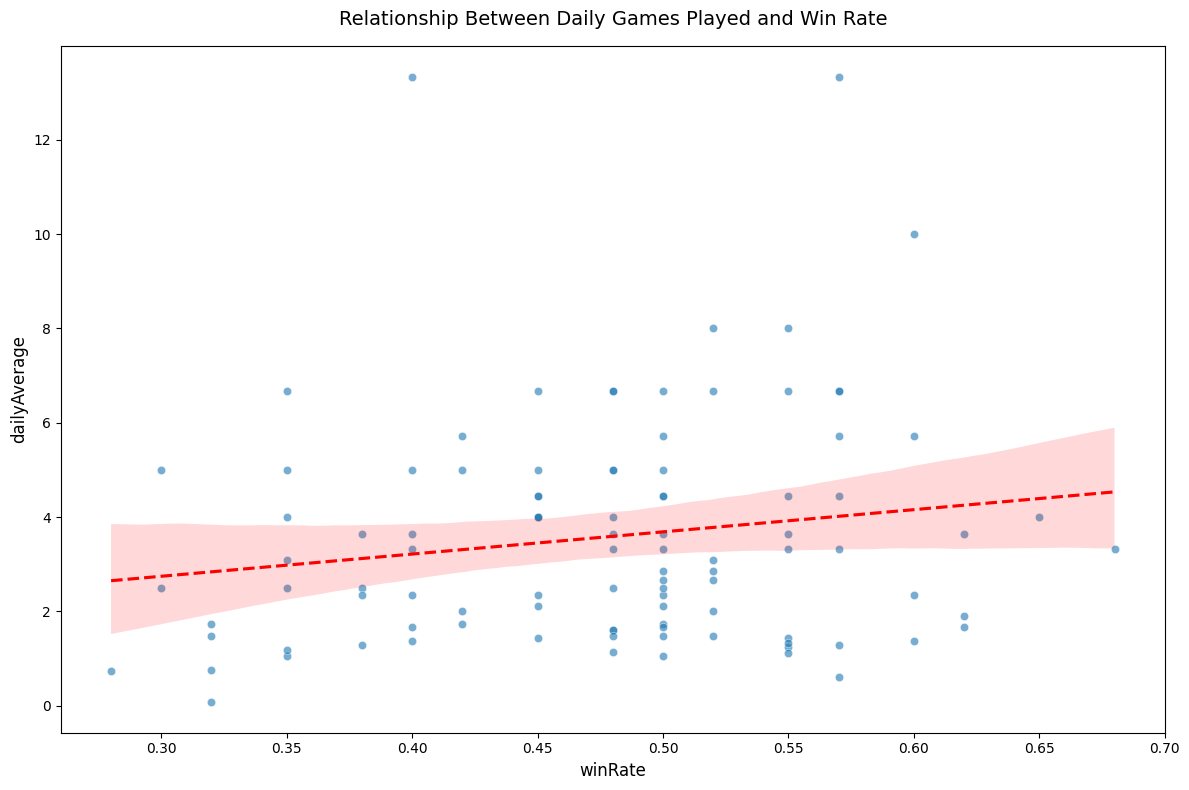

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV file for Final_Dataset
df = pd.read_csv('Final_Dataset.csv')

# Set default style for scattergraph
plt.style.use('default')

# Create the scattergraph
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='winRate', y='dailyAverage', alpha=0.6)

# Add title and labels
plt.title('Relationship Between Daily Games Played and Win Rate', fontsize=14, pad=15)
plt.xlabel('Win Rate', fontsize=12)
plt.ylabel('Average Games per Day', fontsize=12)

# Add a trend line
sns.regplot(data=df, x='winRate', y='dailyAverage', scatter=False, color='red', line_kws={'linestyle': '--'})

# Adjust layout
plt.tight_layout()

# Showscattergraph
plt.show()

<h4>What can we tell from the above scatter graph?</h4>

The overall scatter-graph suggests that while the co-relation between daily games played and Daily average is very scarce (not much relation), there is a slight trend where the more games played in a day will result in a higher win rate based on trend line

<h3>4.2 Plotting a Co-relation Heatmap graph</h3>

<p>The aim of the graph below is to deterine wether there is any (or the amount) of co-relation between the 3 statistics, Daily Average number of games played, the Win-rate of the player, and the Average KDA of the player.</p>

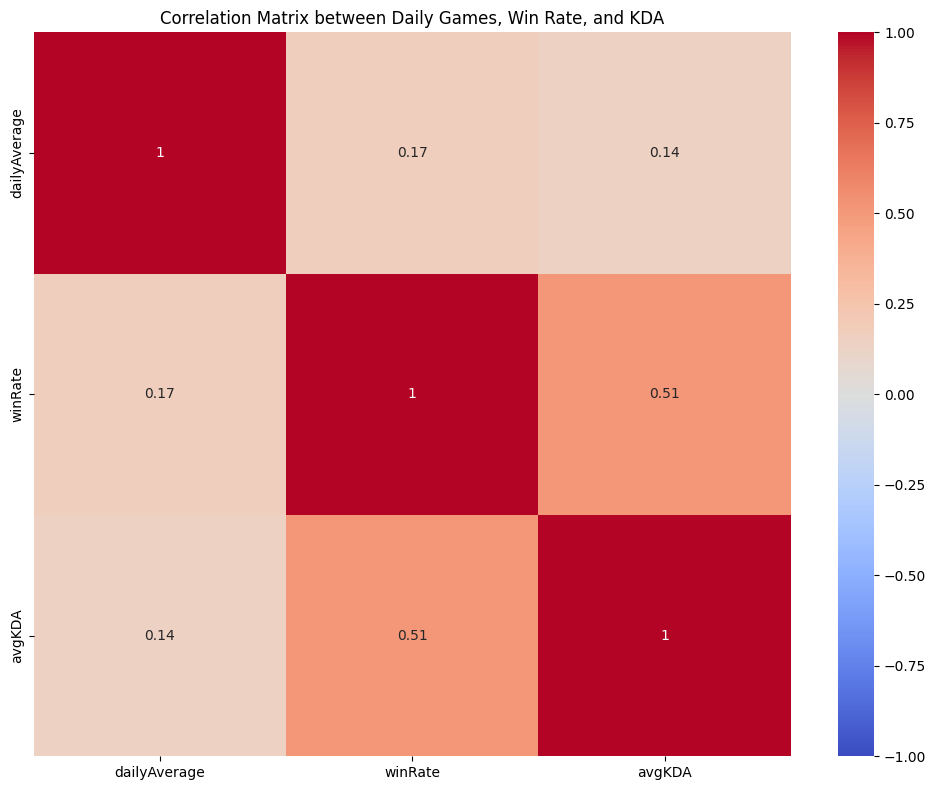


Statistical Analysis:

1. Correlation between Daily Games and Win Rate:
Correlation coefficient: 0.169
P-value: 0.093

2. Correlation between Daily Games and KDA:
Correlation coefficient: 0.141
P-value: 0.162

3. Correlation between Win Rate and KDA:
Correlation coefficient: 0.511
P-value: 0.000


In [27]:
from scipy import stats

# Read the data
df = pd.read_csv('Final_Dataset.csv')

# 1. Calculate correlation matrix
correlation_matrix = df[['dailyAverage', 'winRate', 'avgKDA']].corr()

# 2. Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            vmin=-1, vmax=1,  # Value range
            center=0)  # Center point for color scheme
plt.title('Correlation Matrix between Daily Games, Win Rate, and KDA')
plt.tight_layout()
plt.show()

# 3. Print statistical summary
print("\nStatistical Analysis:")
print("\n1. Correlation between Daily Games and Win Rate:")
corr_games_winrate = stats.pearsonr(df['dailyAverage'], df['winRate'])
print(f"Correlation coefficient: {corr_games_winrate[0]:.3f}")
print(f"P-value: {corr_games_winrate[1]:.3f}")

print("\n2. Correlation between Daily Games and KDA:")
corr_games_kda = stats.pearsonr(df['dailyAverage'], df['avgKDA'])
print(f"Correlation coefficient: {corr_games_kda[0]:.3f}")
print(f"P-value: {corr_games_kda[1]:.3f}")

print("\n3. Correlation between Win Rate and KDA:")
corr_winrate_kda = stats.pearsonr(df['winRate'], df['avgKDA'])
print(f"Correlation coefficient: {corr_winrate_kda[0]:.3f}")
print(f"P-value: {corr_winrate_kda[1]:.3f}")